[In English](../use-case_skewt-interactive_en/)

![ECCC logo](https://eccc-msc.github.io/open-data/img_eccc-logo.png)

[Tdm](https://eccc-msc.github.io/open-data/readme_fr/) > [Aperçu de l'utilisation](https://eccc-msc.github.io/open-data/usage/readme_fr/) > Requêtes WMS en Python

# Cas d'utilisation : traçage de profils verticaux basés sur les données ouvertes

## Introduction

Les données météorologiques, climatiques et hydrométriques des services web géospatiaux [GeoMet du SMC](https://eccc-msc.github.io/open-data/msc-geomet/readme_fr/) peuvent aisément être utilisées pour prévoir la demande associée à certains produits ou services. Cet exemple de cas d'utilisation montre comment extraire et traiter les données de radiosondage brutes à l'aide du langage de programmation [Python](https://www.python.org/) afin de créer un outil permettant de tracer et d'afficher des informations en fonction des données fournies. La version interactive est beaucoup plus complète et dispose d'une interface (lien ci-dessous), mais le code est très complexe et cet exemple plus simple a été conçu comme un outil d'enseignement. Il permet d'apprendre comment :
* Accéder aux données de radiosondage brutes de GeoMet du SMC et les interroger;
* Effectuer des requêtes pour obtenir les données d'une couche spécifique à un lieu précis; 
* Effectuer des requêtes temporelles;
* Afficher les résultats sous forme de graphique et de tableau.

La [version simple de ce Jupyter Notebook est disponible ici](https://mybinder.org/v2/gh/PhilippeTh/open-data/Gerald_SkewT_Use_case_PT?labpath=%2Fdocs%2Fusage%2Fuse-case_skewt%2Fuse-case_skewt_fr.ipynb).

[![badge](https://img.shields.io/badge/Version%20simple-binder-579ACA.svg?logo=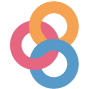)](https://mybinder.org/v2/gh/PhilippeTh/open-data/Gerald_SkewT_Use_case_PT?labpath=%2Fdocs%2Fusage%2Fuse-case_skewt%2Fuse-case_skewt_fr.ipynb)

La [version interactive (cette version) de ce Jupyter Notebook est disponible ici](https://mybinder.org/v2/gh/PhilippeTh/open-data/Gerald_SkewT_Use_case_PT?labpath=%2Fdocs%2Fusage%2Fuse-case_skewt%2Fuse-case_skewt-interactive_fr.ipynb).

[![badge](https://img.shields.io/badge/Version%20interactive-binder-F5A252.svg?logo=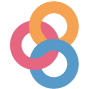)](https://mybinder.org/v2/gh/PhilippeTh/open-data/Gerald_SkewT_Use_case_PT?labpath=%2Fdocs%2Fusage%2Fuse-case_skewt%2Fuse-case_skewt-interactive_fr.ipynb)

## Creation d'un outil pour extraire et tracer les données de sonde

Considérons la situation suivante : Gérald, pilote d'avion, aimerait pouvoir accéder aux observations en altitude des données canadiennes de manière facilement compréhensible et précise. Il peut en avoir besoin à tout moment de la journée et il aimerait connaître les prévisions pour un vol à venir. Un ami lui a également dit qu'il pourrait y avoir des conditions météorologiques défavorables sur la trajectoire qu'il a choisie. Gerald aimerait donc vérifier cette information par lui-même et voir s'il doit modifier sa trajectoire ou même retarder ou annuler son vol. Gerald souhaite pouvoir obtenir les informations dont il a besoin en temps voulu en utilisant les prévisions de radiosondage obtenues auprès des services web géospatiaux de GeoMet du SMC.

Pour être en mesure de voir les données pour une heure et un lieu spécifiques, la première étape consiste à interroger le processus ``Extract Sounding Data Geomet OGC API Process`` de GeoMet du SMC pour obtenir les données associées avec le modèle, la passe de modèle, l'heure de prévision et la lat/lon par le biais de la programmation Python. Pour réaliser cette étape, les modules Python doivent d'abord être importés et des valeurs doivent être données aux paramètres de la requête. La couche utilisée pour cet exemple sera la couche du [Système global de prévision déterministe (SGPD)](https://eccc-msc.github.io/open-data/msc-data/nwp_gdps/readme_gdps_fr/) qui contient les prévisions déterministes des éléments de l'atmosphère du jour présent jusqu'à 10 jours dans le futur (``GDPS.ETA_TT``).

In [ ]:
# Retirer cette commande si le code roule à l'extérieur d'un Jupyter Notebook
%matplotlib widget

# Importation de modules Python
import base64
from datetime import datetime
import io
import logging
import math
import re
import requests

# Tous les modules suivants doivent d'abord être installés pour
# pouvoir utiliser ce code hors de ce Jupyter Notebook
from adjustText import adjust_text
from ipyleaflet import Map
from ipywidgets import BoundedFloatText, Button, Checkbox, Dropdown, HBox, HTML, Label, Output, Text, VBox

from matplotlib.font_manager import FontProperties
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as mpatheffects
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import metpy.calc as mpcalc
import metpy.interpolate as mpinterpolate

# logging utilisé uniquement afin d'enlever un avertissement Cartopy inutile de Metpy
metpy_plot_logger = logging.getLogger('metpy.plots')
metpy_plot_logger.setLevel(logging.ERROR)

from metpy.plots import Hodograph, SkewT
from metpy.units import units

from owslib.wms import WebMapService
from pandas import date_range
import PIL

# Le format horaire utilisé est UTC±00:00
ISO_FORMAT = '%Y-%m-%dT%H:%M:%SZ'

Une fois les librairies importées, nous créons une classe pour encapsuler la fonction de création des graphiques afin qu'elle puisse être appelée quand nous le souhaitons et avec différents arguments.

In [ ]:
class SoundingProcessRequest():
    """
    Classe utilisée pour effectuer la requête OAProc.
    """

    def __init__(self, fh, lat, lon, model, mr, convection_indices=True, temperature_data=True, wind_data=True, noval=True, url=None) -> None:
        """
        :param fh: string -> Heure de prévision qui commence par 3 chiffres (par exemple 003).
        :param lat: float -> Latitude (i.e. -12.3456).
        :param lon: float -> Longitude (i.e. 123.4567).
        :param model: string -> SRPD, SGPD ou SHRPD.
        :param mr: string -> Passe de modèle en format ISO (i.e. 2022-01-31T12:00:00Z).
        :param convection_indices: bool -> True (par défaut) signifie que vous souhaitez avoir les indices de convection;
                                           False signifie que vous n'en aurez pas besoin.
        :param temperature_data: bool -> True (default) signifie que vous souhaitez avoir les données de température et de point de rosée;
                                         False signifie que vous n'en aurez pas besoin.
        :param wind_data: bool -> True (default) signifie que vous souhaitez avoir les données de vent;
                                  False signifie que vous n'en aurez pas besoin.
        :param noval: bool -> True (default) signifie que vous n'avez pas besoin des niveaux de pression au-dessus de 100mbar;
                              False signifie que vous voulez tous les niveaux de pression (peut échouer lors de la création de graphiques de radiosondage ou les rendre illisibles).
        :param url: string -> URL pleinement qualifiée du processus OGC API extract-sounding-data.
        """
        self.forecast_hour = fh
        self.lat = lat
        self.lon = lon
        self.model = model
        self.model_run = mr
        self.convection_indices = convection_indices
        self.temperature_data = temperature_data
        self.wind_data = wind_data
        self.novalues_above_100mbar = noval
        self.url = url or 'https://api.weather.gc.ca/processes/extract-sounding-data/execution'
        self.data = self.__create_request()

    def __create_request(self):
        """
        Faites la demande à l'OAProc extract-sounding-data en utilisant les informations données.
        """
        headers = {
            'Accept': 'application/json',
            'Content-Type': 'application/json',
        }
        body = {
            'inputs': {
                'forecast_hour': self.forecast_hour[0:3],
                'lat': self.lat,
                'lon': self.lon,
                'model': equivalences_modeles[self.model],
                'model_run': self.model_run,
                'convection_indices': self.convection_indices,
                'temperature_data': self.temperature_data,
                'wind_data': self.wind_data,
                'novalues_above_100mbar': self.novalues_above_100mbar,
            }
        }
        resp = requests.post(self.url, json=body, headers=headers)
        return resp.json()


class SoundingGraphs(SoundingProcessRequest):
    """
    Classe permettant de créer le SkewT, l'Hodographe et le tableau des indices de convection.
    """

    def __init__(self, fh, lat, lon, model, mr, convection_indices=True, temperature_data=True, wind_data=True, noval=True, url=None) -> None:
        """
        :param fh: string -> Heure de prévision qui commence par 3 chiffres (par exemple 003).
        :param lat: float -> Latitude (i.e. -12.3456).
        :param lon: float -> Longitude (i.e. 123.4567).
        :param model: string -> SRPD, SGPD ou SHRPD.
        :param mr: string -> Passe de modèle en format ISO (i.e. 2022-01-31T12:00:00Z).
        :param convection_indices: bool -> True (par défaut) signifie que vous souhaitez avoir les indices de convection;
                                           False signifie que vous n'en aurez pas besoin.
        :param temperature_data: bool -> True (default) signifie que vous souhaitez avoir les données de température et de point de rosée;
                                         False signifie que vous n'en aurez pas besoin.
        :param wind_data: bool -> True (default) signifie que vous souhaitez avoir les données de vent;
                                  False signifie que vous n'en aurez pas besoin.
        :param noval: bool -> True (default) signifie que vous n'avez pas besoin des niveaux de pression au-dessus de 100mbar;
                              False signifie que vous voulez tous les niveaux de pression (peut échouer lors de la création de graphiques de radiosondage ou les rendre illisibles).
        :param url: string -> URL pleinement qualifiée du processus OGC API extract-sounding-data.
        """
        super().__init__(fh, lat, lon, model, mr, convection_indices, temperature_data, wind_data, noval, url)
        plt.ioff()
        plt.close('all')
        self.p = [] # Liste pour stocker les niveaux de pression
        self.t = [] # Liste pour stocker les températures
        self.td = [] # Liste pour stocker les températures du point de rosée
        self.ws = [] # Liste pour stocker les vitesses du vent
        self.wd = [] # Liste pour stocker les directions du vent
        self.deg_symbol = u'\N{DEGREE SIGN}'
        self.__sort_data()

    def __sort_data(self):
        """
        Stocker les données de radiosondage du fichier json retourné par le processus.
        """
        # Stocker toutes les données de radiosondage
        if self.temperature_data and self.wind_data:
            for key, val in self.data['properties'].items():
                if re.search(r'(\d+)mbar', key):
                    self.p.append(val['pressure'])
                    self.t.append(val['air_temperature'])
                    self.td.append(val['dew_point_temperature'])
                    self.ws.append(val['wind_speed'])
                    self.wd.append(val['wind_direction'])
            self.p *= units.hPa
            self.t *= units.degC
            self.td *= units.degC
            self.ws *= units.knots
            self.wd *= units.degrees
            self.u, self.v = mpcalc.wind_components(self.ws, self.wd)
        # Le cas où vous avez la température et le point de rosée, mais pas d'informations
        # sur le vent ne vous permet pas de construire un SkewT ni un Hodographe, mais le
        # cas est présent au cas où.
        elif self.temperature_data:
            for key, val in self.data['properties'].items():
                if re.search(r'(\d+)mbar', key):
                    self.p.append(val['pressure'])
                    self.t.append(val['air_temperature'])
                    self.td.append(val['dew_point_temperature'])
            self.p *= units.hPa
            self.t *= units.degC
            self.td *= units.degC
        elif self.wind_data:
            for key, val in self.data['properties'].items():
                if re.search(r'(\d+)mbar', key):
                    self.p.append(val['pressure'])
                    self.ws.append(val['wind_speed'])
                    self.wd.append(val['wind_direction'])
            self.p *= units.hPa
            self.ws *= units.knots
            self.wd *= units.degrees
            self.u, self.v = mpcalc.wind_components(self.ws, self.wd)

        # Stocker les indices de convection afin de pouvoir les placer à l'intérieur d'une table
        if self.convection_indices:
            cape = list(self.data['properties']['CAPE'].values())
            cin = list(self.data['properties']['CIN'].values())
            lcl = list(self.data['properties']['LCL'].values())
            li = list(self.data['properties']['LI'].values())
            lfc = list(self.data['properties']['LFC'].values())
            el = list(self.data['properties']['EL'].values())

            # Réorganiser les valeurs pour obtenir la première valeur de chaque liste dans la même ligne
            self.conv_indices = conv_indices = [list(row) for row in zip(cape, cin, lcl, li, lfc, el)]
            for i, row in enumerate(conv_indices):
                for j, elem in enumerate(row):
                    # Arrondir les valeurs
                    if isinstance(elem, float):
                        conv_indices[i][j] = round(conv_indices[i][j])

            # Ajouter les unités sur la dernière ligne du tableau
            if self.data['properties']['LI_unit'] == "--":
                self.data['properties']['LI_unit'] = "K"
            conv_indices.append(
                [self.data['properties']['CAPE_unit'],
                 self.data['properties']['CIN_unit'],
                 self.data['properties']['LCL_unit'],
                 self.data['properties']['LI_unit'],
                 self.data['properties']['LFC_unit'],
                 self.data['properties']['EL_unit']]
            )

    def create_skewt(self, hodograph=False, convection_table=False):
        """
        Fonction utilisée pour créer un graphique SkewT.
        :param hodograph: bool -> True signifie qu'un hodographe sera également ajouté.
        :param convection_table: bool -> True signifie qu'une table d'indices de convection sera également ajoutée.
        """
        # La taille de la figure doit être modifiée selon le nombres d'items à l'intérieur
        if hodograph and convection_table:
            self.fig = plt.figure(figsize=(16, 18), tight_layout=True)
            gs = gridspec.GridSpec(3, 1, height_ratios=(8, 8, 1))
            skew = SkewT(self.fig, rotation=45, subplot=gs[0])
        elif hodograph:
            self.fig = plt.figure(figsize=(14, 14), tight_layout=True)
            gs = gridspec.GridSpec(2, 1)
            skew = SkewT(self.fig, rotation=45, subplot=gs[0])
        elif convection_table:
            self.fig = plt.figure(figsize=(14, 9), tight_layout=True)
            gs = gridspec.GridSpec(2, 1, height_ratios=(8, 1))
            skew = SkewT(self.fig, rotation=45, subplot=gs[0])
        else:
            self.fig = plt.figure(figsize=(10, 8))
            skew = SkewT(self.fig, rotation=45)

        # Tracer les données à l'aide de fonctions de traçage normales, dans ce cas en
        # utilisant l'échelle logarithmique en Y, comme le veut le tracé météorologique typique
        skew.plot(self.p[:len(self.t)], self.t, 'r', label='Température')
        skew.plot(self.p[:len(self.td)], self.td, 'g', label='Point de rosée')
        skew.plot_barbs(self.p[:len(self.ws)], self.u, self.v)
        skew.ax.set_ylim(1050, 100)
        skew.ax.set_xlim(-40, 60)
        skew.ax.xaxis.set_label_text('Température (°C)')
        skew.ax.yaxis.set_label_text('Pression (hPa|mbar)')

        # Ajouter un axe secondaire qui convertit automatiquement entre la pression et la 
        # hauteur en supposant une atmosphère standard. La valeur de -0,12 place l'axe
        # secondaire 0,12 coordonnées normalisées (0 à 1) à gauche de l'axe original
        secax = skew.ax.secondary_yaxis(
            -0.12,
            functions=(
                lambda p: mpcalc.pressure_to_height_std(units.Quantity(p, 'hPa')).m_as('km'),
                lambda h: mpcalc.height_to_pressure_std(units.Quantity(h, 'km')).m
            )
        )

        # Afficher les marques 0, 1, 3, 6, 9, 12, 15 km
        secax.yaxis.set_major_locator(plt.FixedLocator([0, 1, 3, 6, 9, 12, 15]))
        secax.yaxis.set_minor_locator(plt.NullLocator())
        secax.yaxis.set_major_formatter(plt.ScalarFormatter())
        secax.set_ylabel('Hauteur (km)')

        # Calculer le profil de la parcelle complet et l'ajouter au tracé sous forme de ligne noire
        prof = mpcalc.parcel_profile(self.p, self.t[0], self.td[0]).to('degC')
        skew.plot(self.p, prof, 'k', linewidth=2, label='Profil de la parcelle*')

        # Remplir les zones de CAPE et CIN
        skew.shade_cin(self.p, self.t, prof, self.td, label='CIN*')
        skew.shade_cape(self.p, self.t, prof, label='CAPE*')

        # Ligne oblique à l'isotherme 0
        skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

        # Ajouter les lignes spéciales appropriées
        wet_bulb = mpcalc.wet_bulb_temperature(self.p, self.t, self.td)
        skew.plot(self.p, wet_bulb, 'b', linewidth=1, label='Thermomètre mouillé*')
        skew.plot_dry_adiabats()
        skew.plot_moist_adiabats()
        skew.plot_mixing_lines()

        # Ajouter un titre avec toutes les données utilisées pour le tracé
        skew.ax.title.set_text(f'Radiosondage {self.model} pour (' +
                                f'{str(self.lat) + self.deg_symbol + "N" if self.lat >= 0 else str(self.lat*-1) + self.deg_symbol + "S"}, ' +
                                f'{str(self.lon) + self.deg_symbol + "E" if self.lon >= 0 else str(self.lon*-1) + self.deg_symbol + "O"}) ' + '\n' +
                                f'Passe de modèle: {self.model_run} ' + '\n' +
                                f'Heure de prévision: {self.forecast_hour[0:5]}{datetime.strptime(self.forecast_hour[5:], "%Y-%m-%d %H:%M:%S").strftime(ISO_FORMAT)}'
                               )
        skew.ax.legend()

        if hodograph:
            self.create_hodograph(gs=gs)

        if convection_table:
            self.create_conv_table(gs)

    def create_hodograph(self, gs=None, convection_table=False):
        """
        Fonction utilisée pour créer un Hodographe.
        :param gs: gridspec.GridSpec -> Nécessaire lorsqu'appelé à partir de create_skewt pour que l'Hodographe apparaisse
                                        sous le graphique SkewT et le tableau des indices de convection sous l'Hodographe.
        :param convection_table: bool -> True signifie qu'une table d'indices de convection sera également ajoutée.
                                         False lorsqu'appelé à partir de create_skewt puisque cette fonction créera la table directement.
        """
        if gs:
            skewt = True
            ax = self.fig.add_subplot(gs[1])
        elif convection_table:
            skewt = False
            self.fig = plt.figure(figsize=(14, 9), tight_layout=True)
            gs = gridspec.GridSpec(2, 1, height_ratios=(8, 1))
            ax = self.fig.add_subplot(gs[0])
        else:
            skewt = False
            self.fig = plt.figure(figsize=(10, 8))
            ax = self.fig.add_subplot(1, 1, 1)

        # Valeurs du niveau de pression à afficher sur l'Hodographe si elles sont présentes
        # Vous pouvez en ajouter ou en supprimer à votre guise
        boundaries_default = [950, 850, 700, 500, 300, 250]

        # Toujours afficher le premier niveau de pression
        boundaries_p = [self.p[0].magnitude]

        # Afficher également tous ceux de la liste ci-dessus, mais seulement s'ils sont plus hauts que
        # le premier niveau de pression et sont au moins 50mbar au-dessus du premier niveau de pression.
        # Par exemple, si le premier niveau de pression est à 855mbar, ne pas afficher 950 ni 850.
        boundaries_p.extend([bd for bd in boundaries_default if ((boundaries_p[0]-bd)>=50 and bd>=self.p[-1].magnitude)])
        boundaries_p *= units.hPa
        u_pts, v_pts = mpinterpolate.interpolate_1d(boundaries_p, self.p, self.u, self.v)
        boundaries_p[0] = round(boundaries_p[0])

        # Ajouter les points sur l'Hodographe pour les niveaux de pression choisis
        ax.scatter(u_pts, v_pts, c="black", zorder=10)
        texts = []
        for up, vp, z in zip(u_pts, v_pts, boundaries_p):
            z_str = int(z.magnitude)
            texts.append(ax.text(up, vp, z_str, ha='center', fontsize=10,
                         path_effects=[mpatheffects.withStroke(foreground='white', linewidth=2)],
                         zorder=12)
                        )

        # Échelle de l'Hodographe en fonction de la valeur du vent la plus élevée
        max_range = math.ceil(max(self.ws).magnitude) + 1
        h = Hodograph(ax, component_range=max_range)

        if max_range < 50:
            inc = math.ceil(max_range / 10)
        else:
            inc = 5 * math.ceil(max_range / 100)

        # Ajouter des axes au centre du graphique
        ax.spines['left'].set_position('zero')
        ax.spines['bottom'].set_position('zero')
        ax.patch.set_edgecolor('black')
        ax.patch.set_linewidth(0.5)

        # Ajouter une couleur qui change en fonction des niveaux de pression
        h.plot_colormapped(self.u, self.v, self.p)

        # Redimensionner l'Hodographe pour zoomer là où se trouvent les valeurs
        # Commentez h.ax.autoscale() si vous voulez l'Hodographe entier à la place
        h.ax.autoscale()
        bottom, top = h.ax.get_ylim()
        left, right = h.ax.get_xlim()

        # Ajouter les lignes de la grille pour les vitesses de vent
        h.add_grid(increment=inc)

        # S'assurer que les axes restent à l'intérieur du graphique si les vents sont tous très éloignés dans une direction
        if left > 0:
            left = -1
        if bottom > 0:
            bottom = -1
        if right < 0:
            right = 1
        if top < 0:
            top = 1

        # Redimensionner l'hodographe pour zoomer sur le graphique,
        # mais n'afficher que les valeurs d'axe sur l'axe le plus long
        # et ajouter un petit tampon pour s'assurer que l'ensemble du
        # tracé reste toujours visible
        norm_bottom = abs(bottom)
        norm_left = abs(left)
        whole, remainder = divmod(max_range, inc)
        highest = max(norm_bottom, top, norm_left, right)
        if highest in (norm_bottom, top):
            if highest == norm_bottom:
                norm_bottom = (whole + math.ceil(remainder/inc)) * inc
            else:
                top = (whole + math.ceil(remainder/inc)) * inc
            ax.set_ylim(bottom=-norm_bottom, top=top)
            ax.set_xlim(left=-norm_left, right=right)

            ax.yaxis.set_major_locator(mticker.MultipleLocator(inc))
            ticks_loc_y = ax.get_yticks().tolist()
            ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc_y))
            ax.set_yticklabels([f'{abs(int(y))}' for y in ticks_loc_y])
            ax.set_xticks([])
        else:
            if highest == norm_left:
                norm_left = (whole + math.ceil(remainder/inc)) * inc
            else:
                right = (whole + math.ceil(remainder/inc)) * inc
            ax.set_ylim(bottom=-norm_bottom, top=top)
            ax.set_xlim(left=-norm_left, right=right)

            ax.xaxis.set_major_locator(mticker.MultipleLocator(inc))
            ticks_loc_x = ax.get_xticks().tolist()
            ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc_x))
            ax.set_xticklabels([f'{abs(int(x))}' for x in ticks_loc_x])
            ax.set_yticks([])

        # Supprimer les étiquettes car les axes sont au milieu du graphique
        ax.set_xlabel('')
        ax.set_ylabel('')

        # Ajouter le titre complet s'il n'y a pas de diagramme SkewT
        if skewt:
            h.ax.title.set_text('Hodographe, Vitesse du vent en noeuds, Hauteur en hPa')
        else:
            h.ax.title.set_text(f'Radiosondage {self.model} pour (' +
                                f'{str(self.lat) + self.deg_symbol + "N" if self.lat >= 0 else str(self.lat*-1) + self.deg_symbol + "S"}, ' +
                                f'{str(self.lon) + self.deg_symbol + "E" if self.lon >= 0 else str(self.lon*-1) + self.deg_symbol + "O"}) ' + '\n' +
                                f'Passe de modèle: {self.model_run} ' + '\n' +
                                f'Heure de prévision: {self.forecast_hour[0:5]}{datetime.strptime(self.forecast_hour[5:], "%Y-%m-%d %H:%M:%S").strftime(ISO_FORMAT)}' + '\n' +
                                'Hodographe, Vitesse du vent en noeuds, Hauteur en hPa'
                               )
        # Veiller à ce que le texte des points dans l'hodographe ne se chevauchent pas
        adjust_text(texts, arrowprops=dict(arrowstyle='->', color='r', lw=0.5), expand_text=(5, 5))

        if convection_table:
            self.create_conv_table(gs)

    def create_conv_table(self, gs=None):
        """
        Fonction utilisée pour créer un tableau d'indices de convection.
        :param gs: gridspec.GridSpec -> Nécessaire lorsqu'elle est appelée depuis create_skewt ou create_hodograph
                                        pour que le tableau apparaisse sous les graphiques.
        """
        if gs:
            table_ax = self.fig.add_subplot(gs[-1])
        else:
            self.fig = plt.figure(figsize=(14, 4), tight_layout=True)
            table_ax = self.fig.add_subplot(1, 1, 1)
        table_ax.axis('tight')
        table_ax.axis('off')

        # Nom des colonnes et des lignes du tableau
        col_names = ['CAPE', 'CIN', 'LCL', 'LI', 'LFC', 'EL']
        row_names = ['SFC', 'ML', 'MU', 'Unités']
        tab = table_ax.table(cellText=self.conv_indices, colLabels=col_names, rowLabels=row_names, loc='center', cellLoc='center')

        # Modifier la taille et l'échelle de la police du tableau pour améliorer la lisibilité
        tab.auto_set_font_size(False)
        tab.set_fontsize(12)
        tab.scale(1.5, 1.5)

        # Remplir le tableau
        for (row, col), cell in tab.get_celld().items():
            # Mettre les titres des lignes et des colonnes en gras
            if (row == 0) or (col == -1):
                cell.set_text_props(fontproperties=FontProperties(size=12, weight='bold'))

        # Ajouter le titre complet s'il n'y a rien d'autre que le tableau
        if not gs:
            table_ax.title.set_text(f'Radiosondage {self.model} pour (' +
                                    f'{str(self.lat) + self.deg_symbol + "N" if self.lat >= 0 else str(self.lat*-1) + self.deg_symbol + "S"}, ' +
                                    f'{str(self.lon) + self.deg_symbol + "E" if self.lon >= 0 else str(self.lon*-1) + self.deg_symbol + "O"}) ' + '\n' +
                                    f'Passe de modèle: {self.model_run} ' + '\n' +
                                    f'Heure de prévision: {self.forecast_hour[0:5]}{datetime.strptime(self.forecast_hour[5:], "%Y-%m-%d %H:%M:%S").strftime(ISO_FORMAT)}'
                                   )
        

Ensuite, nous créons quelques fonctions utiles qui nous aideront à remplir les heures de prévision et les passes de modèle et à les remplir à nouveau lorsqu'il y a un changement de modèle ou, dans le cas des heures de prévision, lorsqu'il y a aussi un changement de passe de modèle. Cela est possible grâce à une requête ``GetCapabilities`` de la fonction ``wms_request``, qui retournera la première et la dernière heure disponible ainsi que l'intervalle entre les deux et la valeur par défaut.

La fonction ``run_hours`` va alors créer une liste à partir des valeurs obtenues par le ``GetCapabilities`` et la fonction ``time_parameters`` va les formater correctement et retourner la liste créée, la valeur par défaut et l'intervalle.

In [ ]:
def time_parameters(wms, layer, time_field):
    """
    Retourne une liste de dates, la valeur par défaut et l'intervalle entre chaque valeur.

    :param wms: owslib.map.wms130.WebMapService_1_3_0 object -> GetCapabilities sur la couche spécifiée.
    :param layer: string -> Couche interrogée.
    :param time_field: string -> Nom du champ à rechercher dans le GetCapabilities.
    """
    start_time, end_time, interval = (wms[layer]
                                      .dimensions[time_field]['values'][0]
                                      .split('/')
                                      )
    default = wms[layer].dimensions[time_field]['default']
    default = datetime.strptime(default, ISO_FORMAT)
    start_time = datetime.strptime(start_time, ISO_FORMAT)
    end_time = datetime.strptime(end_time, ISO_FORMAT)
    interval = re.sub(r'\D[a-zA-Z]', '', interval)
    return run_hours(start_time, end_time, interval), default, int(re.sub(r'\D', '', interval))

def run_hours(start_time, end_time, interval):
    """
    Crée une liste de dates à partir de start_time, end_time et interval.

    :param start_time: objet datetime
    :param end_time: objet datetime
    :param interval: int -> Nombre d'heures séparant chaque pas de temps dans la liste.
    """
    return date_range(start=start_time,end=end_time, freq=interval).to_pydatetime().tolist()

def wms_request(layer):
    """
    GetCapabilities sur la couche spécifiée.

    :param layer: string -> Couche interrogée.
    """
    return WebMapService('https://geo.weather.gc.ca/geomet?SERVICE=WMS' +
                         '&REQUEST=GetCapabilities' + f'&LAYERS={layer}',
                         version='1.3.0',
                         timeout=300)

On crée une fonction ``create_dropdown`` au lieu de créer 3 menus déroulants.
En utilisant ``GDPS`` comme valeur par défaut, faire les requêtes ``GetCapabilities`` et remplir les menus déroulants des heures de prévision et des passes de modèle.

In [ ]:
def create_dropdown(options, default_value, desc):
    """
    Fonction permettant de créer des menus déroulants plutôt que de les créer un à un.

    :param options: list -> Tous les choix qui apparaîtront dans le menu déroulant.
    :param default_value: String -> Une valeur à l'intérieur de "options" qui apparaîtra comme valeur par défaut.
    :param desc: String -> Nom du menu déroulant.
    """
    return Dropdown(
        options=options,
        value=default_value,
        description=desc,
        disabled=False,
    )

# Modèle (SGPD, SRPD ou SHRPD), les noms des modèles
# sont utilisés en anglais pour les besoins du code:
equivalences_modeles = {
    "SGPD": "GDPS",
    "SRPD": "RDPS",
    "SHRPD": "HRDPS"
}

# Dictionnaire permettant d'associer un modèle à son nom de couche pour la fonction GetCapabilities
LAYERS = {
    'GDPS': 'GDPS.ETA_TT',
    'RDPS': 'RDPS.ETA_TT',
    'HRDPS': 'HRDPS.CONTINENTAL_TT',
}

# Créer un menu déroulant pour la sélection du modèle
model = create_dropdown(list(equivalences_modeles.keys()), 'SGPD', 'Modèle')

# Faire la requête GetCapabilities sur la couche sélectionnée, dans ce cas SGPD (par défaut)
wms = wms_request(LAYERS[equivalences_modeles[model.value]])

# Obtenir les options et la valeur par défaut pour remplir le menu déroulant Passe de modèle
mr, mr_default, _ = time_parameters(wms, LAYERS[equivalences_modeles[model.value]], 'reference_time')
model_run = create_dropdown(mr, mr_default, 'Passe de modèle: ')

# Obtenir les options et la valeur par défaut pour remplir le menu déroulant Heure de prévision
fhs, fh_default, interval = time_parameters(wms, LAYERS[equivalences_modeles[model.value]], 'time')
forecast_hour = create_dropdown([f'{interval*i:03}: {fh}' for i, fh in enumerate(fhs)],
                                 f'{int((fh_default - fhs[0]).total_seconds() / 3600):03}: {fh_default}',
                                 'Heure de prévision: ')

# Faire en sorte que les menus déroulants "Passe de modèle" et "Heure de prévision" apparaissent côte à côte
time_select = HBox([model_run, forecast_hour])

Créez 3 cases à cocher, elles seront utilisées pour la sélection entre le diagramme ``Skew-T Log-P``, l'``Hodographe``, le ``Tableau des indices de convection`` ou n'importe quelle combinaison d'entre eux que vous souhaitez générer plus tard.

In [ ]:
# Ajouter 3 cases à cocher pour sélectionner les graphiques/tableaux que vous souhaitez voir
skewt_cb = Checkbox(
    value=True,
    description='Skew-T',
    disabled=False,
    indent=False
)
hodo_cb = Checkbox(
    value=True,
    description='Hodographe',
    disabled=False,
    indent=False
)
conv_cb = Checkbox(
    value=True,
    description='Indices de convection',
    disabled=False,
    indent=False
)

# Superposez les cases à cocher et placez-les à côté de la sélection du modèle
checkboxes = VBox([skewt_cb, hodo_cb, conv_cb])
model_select = HBox([model, checkboxes])

Créer des widgets ``BoundedFloatText`` de latitude et de longitude. Ces champs ne peuvent contenir que des nombres et des décimales et vous pouvez soit taper les latitudes/longitudes à la main, soit entrer l'ID d'une station dans le champ ID de la station, soit cliquer sur la carte (l'ID de la station et la carte apparaissent plus loin dans le code).

Créer également un bouton ``generate_button`` qui sera utilisé pour appeler les fonctions de tracé en utilisant toutes les informations des champs.

In [ ]:
# Position de départ de la carte (à peu près le centre du Canada)
center = [56.1303, -106.3468]

# Latitude et longitude sélectionnées par l'utilisateur
latitude = BoundedFloatText(
    value=center[0],
    min=-90.0,
    max=90.0,
    step=0.0001,
    description='Lat:',
    disabled=False,
    color='black'
)
longitude = BoundedFloatText(
    value=center[1],
    min=-180.0,
    max=180.0,
    step=0.0001,
    description='Lon:',
    disabled=False,
    color='black'
)

# Bouton pour lancer la génération de graphiques/tableaux
generate_button = Button(
    description='Générer',
    disabled=False,
    button_style='',
    tooltip="Cliquer pour générer ce que vous avez sélectionné",
    icon='line-chart'
)

# Placer la latitude et la longitude côte à côte
latlon = HBox([latitude, longitude])

Utiliser l'url ci-dessous pour récupérer tous les identifiants, noms et latitudes/longitudes de stations possibles et les stocker dans un ``dictionnaire``. Créer une zone de texte dans laquelle l'identifiant de la station peut être saisi et, en utilisant le gestionnaire d'événement ``on_submit``, remplir les champs de latitude et de longitude avec la latitude/longitude de l'identifiant de la station. Créer également une autre zone de texte qui affichera simplement le nom de la station sélectionnée afin de vérifier que vous avez saisi le bon identifiant. La valeur sera "Station invalide" si ce qui a été saisi dans le champ d'identification de la station n'est pas présent dans le fichier.

In [ ]:
# Allez chercher tous les noms de stations dans ce fichier texte
stations_file = 'https://dd.weather.gc.ca/vertical_profile/doc/station_list_for_vertical_profile.txt'
response = requests.get(stations_file)
stations = dict()
get_line = False
# Recherche ligne par ligne à l'aide de Regex pour trouver la station, l'identifiant de la station et ses coordonnées (lon/lat)
for line in response.text.splitlines():
    if line != '' and get_line:
        stn = re.search(r"stn='(.*?)'", line).group(1)
        stn_id = re.search(r"stn_id='*(.*?)'", line).group(1)
        stn_lon = float(re.search(r"lon=([+-]?\d+\.\d+)", line).group(1))
        stn_lat = float(re.search(r"lat=([+-]?\d+\.\d+)", line).group(1))
        stations[stn_id] = {
            'Station': stn,
            'Lon': stn_lon,
            'Lat': stn_lat,
        }
    # Commencer à rechercher des stations après avoir passé cette ligne dans le fichier texte
    if 'Forecast Sites' in line:
        get_line = True

# Zone de texte pour saisir l'ID de la station
station_id = Text(
    value='',
    placeholder='ex.: CYVO',
    description='Id Station: ',
    disabled=False
)

# Zone de texte non modifiable pour afficher le nom de la station une fois que l'identifiant a été
# saisi (pour vérifier que vous avez saisi l'identifiant correct de la station). Les noms des stations
# dans le fichier texte ne suivent aucune règle (parfois des traits de soulignement, des traits d'union,
# des espaces, etc.) Pour cette raison, cette case n'est là que pour afficher la station sélectionnée
# une fois qu'un identifiant a été saisi et ne peut pas être utilisée pour trouver la station.
station_name = Text(
    value='',
    placeholder='Le nom apparait ici',
    description='Station: ',
    disabled=True
)

# Fonction appelée lorsqu'un identifiant de station a été soumis
def on_station_entered(sender):
    if station_id.value in stations:
        station_name.value = stations[station_id.value]['Station']
        latitude.value = stations[station_id.value]['Lat']
        longitude.value = stations[station_id.value]['Lon']
    # Si l'identifiant de la station ne figure pas dans la liste, indiquez "Station invalide" dans les champs.
    else:
        station_id.value = 'Station invalide'
        station_name.value = 'Station invalide'

# Gestionnaire d'événements pour surveiller la soumission de l'identifiant de la station
station_id.on_submit(on_station_entered)

# Placer les zones de texte ID et nom de la station l'une à côté de l'autre
stations_hbox = HBox([station_id, station_name])

Créer le widget Carte. Il sera utilisé pour afficher la latitude et la longitude actuelles au survol de la carte et pour remplir les champs de latitude et de longitude lors d'un clic sur la carte.

In [ ]:
# Créer une carte qui :
#     Est centrée sur le centre du Canada.
#     A un zoom minimum de 3 afin que vous ne puissiez pas voir plusieurs cartes côte à côte.
#     Utilise le world_copy_jump de sorte que si vous continuez à défiler dans une direction,
#     les lats/lons ne continueront pas à augmenter et vont à la place boucler.
m = Map(center=center,
        scroll_wheel_zoom=True,
        bounce_at_zoom_limits=False,
        double_click_zoom=False,
        min_zoom=3,
        zoom=4,
        world_copy_jump=True)

En utilisant le gestionnaire d'événement ``on_interaction``, créer des événements pour le survol de la carte (afficher la lat/lon actuelle) et le clic sur la carte (remplir les champs latidude et longitude avec la lat/lon de l'endroit où vous avez cliqué). Les conditions ``if`` sont là pour s'assurer que les lat/lon renvoyées par le clic sont dans les limites du monde, sinon elles sont ajustées en conséquence.

In [ ]:
def handle_map_interaction(**kwargs):
    # Si l'on clique sur la carte, les champs lat/lon sont remplis avec la lat/lon choisie
    if kwargs.get('type') == 'click':
        lat, lon = kwargs.get('coordinates')
        if lat > 85.06:
            while lat > 85.06:
                lat -= 170.12
        elif lat < -85.06:
            while lat < -85.06:
                lat += 170.12
        if lon > 180.0:
            while lon > 180.0:
                lon -= 360.0
        elif lon < -180.0:
            while lon < -180.0:
                lon += 360.0
        latitude.value = round(lat, 4)
        longitude.value= round(lon, 4)
    # Lorsque la carte est survolée, afficher les coordonnées actuelles (lat/lon).
    if kwargs.get('type') == 'mousemove':
        lat, lon = kwargs.get('coordinates')
        label.value = str((round(lat, 4), round(lon, 4)))

# Gestionnaire d'événements pour surveiller les interactions avec la carte
m.on_interaction(handle_map_interaction)

En utilisant le gestionnaire d'événements ``observe``, modifier les valeurs des passes de modèle et des heures de prévision possibles pour qu'elles correspondent au nouveau modèle sélectionné.

In [ ]:
def model_change_eventhandler(change):
    """
    Lorsque vous passez d'un modèle à l'autre, les passes de modèle et des heures de prévision doivent être modifiées en conséquence.

    :param change: traitlets.utils.bunch.Bunch object -> Permet d'accéder à l'ancienne et à la nouvelle valeur du menu déroulant Modèle ainsi qu'à d'autres propriétés.
    """
    new_model = equivalences_modeles[change.new]
    wms = wms_request(LAYERS[new_model])
    new_mr, new_mr_default, _ = time_parameters(wms, LAYERS[new_model], 'reference_time')
    model_run.options = new_mr
    model_run.value = new_mr_default

    new_fh, new_fh_default, new_interval = time_parameters(wms, LAYERS[new_model], 'time')
    forecast_hour.options = [f'{new_interval*i:03}: {new_fh[i]}' for i in range(len(new_fh))]
    forecast_hour.value = f'{int((new_fh_default - new_fh[0]).total_seconds() / 3600):03}: {new_fh_default}'

    # Les indices de convection ne sont pas disponibles pour SHRPD
    if change.new == 'SHRPD':
        conv_cb.disabled = True
        conv_cb.value = False
    else:
        conv_cb.disabled = False

# Appeler model_change_eventhandler lorsque la valeur du menu déroulant du modèle est modifiée
model.observe(model_change_eventhandler, names='value')

En utilisant le gestionnaire d'événement ``observe``, modifier les valeurs des heures de prévision possibles pour qu'elles correspondent à la nouvelle passe de modèle sélectionnée.

In [ ]:
def model_run_change_eventhandler(change):
    """
    Lorsque la passe de modèle change, les heures de prévision possibles doivent être modifiées en conséquence.

    :param change: traitlets.utils.bunch.Bunch object -> Permet d'accéder à l'ancienne et à la nouvelle valeur du menu déroulant Passe de modèle ainsi qu'à d'autres propriétés.
    """
    delta = change.old - change.new
    new_fh = [f'{option[:5]}{datetime.strptime(option[5:], "%Y-%m-%d %H:%M:%S") - delta}' for option in forecast_hour.options]
    new_fh_default = f'{forecast_hour.value[:5]}{datetime.strptime(forecast_hour.value[5:], "%Y-%m-%d %H:%M:%S") - delta}'

    forecast_hour.options = new_fh
    forecast_hour.value = new_fh_default

# Appeler model_run_change_eventhandler lorsque la valeur du menu déroulant model_run est modifiée
model_run.observe(model_run_change_eventhandler, names='value')

Créer un widget de sortie pour les graphiques générés et un autre pour le bouton de téléchargement. Les widgets de sortie peuvent être vidés et leur contenu peut être remplacé, ce qui est très utile pour effacer les graphiques précédents et afficher le nouveau ou pour n'afficher le bouton de téléchargement que lorsqu'il y a un graphique. Le code ci-dessous est utilisé pour créer les graphiques, gérer les boutons Générer, Précédent et Suivant et déterminer quand le bouton Télécharger doit être affiché (ainsi que toutes les interactions entre ces boutons).

In [ ]:
# Widget de sortie pour capturer les graphiques et les messages
out = Output()
# Widget de sortie pour le bouton Télécharger
out_download = Output()

class GenerateDownload:

    def __init__(self) -> None:
        # Dictionnaire pour stocker les valeurs des graphiques actuels
        self.current_selection = {}
        # Variable pour stocker l'itérateur des options d'heure de prévision
        self.fh_iter = None

    def widgets_disabled(self, is_disabled, index=None):
        """
        Désactiver les widgets pendant que les graphiques sont générés.

        :param is_disabled: bool -> True pour désactiver les widgets.
        :param index: int -> Index de l'heure de prévision actuelle parmi toutes les options d'heure de prévision.
                             Si vous êtes à la dernière heure de prévision, ne jamais activer le bouton next_button.
                             Si vous êtes à la première heure de prévision, ne jamais activer le bouton previous_button.
        """
        generate_button.disabled = is_disabled
        skewt_cb.disabled = is_disabled
        hodo_cb.disabled = is_disabled
        # Les indices de convection ne sont pas disponibles pour SHRPD, il faut donc les désactiver
        if model.value != 'SHRPD' or is_disabled:
            conv_cb.disabled = is_disabled
        model.disabled = is_disabled
        model_run.disabled = is_disabled
        forecast_hour.disabled = is_disabled
        latitude.disabled = is_disabled
        longitude.disabled = is_disabled
        station_id.disabled = is_disabled
        # N'activer que si l'index est correct
        if index is not None:
            if index != 1:
                previous_button.disabled = is_disabled
            if index != self.fh_iter.last_index:
                next_button.disabled = is_disabled
        # Toujours désactiver lorsque des graphiques sont en train d'être générés
        elif is_disabled:
            previous_button.disabled = is_disabled
            next_button.disabled = is_disabled

    def generate(self):
        """
        Effacer les résultats actuels et générer de nouveaux graphiques.
        """
        # Effacer la sortie présente
        out_download.clear_output()
        # Attendre qu'il y ait quelque chose de nouveau à ajouter avant d'effacer la sortie
        out.clear_output(wait=True)
        # Exécuter le code si l'utilisateur a sélectionné au moins une boite à cocher
        if any([self.current_selection['skewt'], self.current_selection['hodo'], self.current_selection['conv_table']]):
            wind_data = False
            temperature_data = False
            convection_indices = False
            # Modifier les variables en fonction de la sélection de la case à cocher
            if self.current_selection['skewt']:
                wind_data = True
                temperature_data = True
            if self.current_selection['hodo']:
                wind_data = True
            if self.current_selection['conv_table']:
                convection_indices = True
            try:
                # Créer un objet SoundingGraphs avec les données fournies
                sounding = SoundingGraphs(self.current_selection['fh'],
                                          self.current_selection['lat'],
                                          self.current_selection['lon'],
                                          self.current_selection['model'],
                                          self.current_selection['mr'].strftime(ISO_FORMAT),
                                          convection_indices,
                                          temperature_data,
                                          wind_data)
                # Appeler la fonction selon ce qui a été sélectionné
                if self.current_selection['skewt']:
                    sounding.create_skewt(hodograph=self.current_selection['hodo'], convection_table=self.current_selection['conv_table'])
                elif self.current_selection['hodo']:
                    sounding.create_hodograph(convection_table=self.current_selection['conv_table'])
                else:
                    sounding.create_conv_table()
                img_buf = io.BytesIO()
                plt.savefig(img_buf, format='png')
                # Afficher la figure et activer le bouton de téléchargement
                display(PIL.Image.open(img_buf))
                self.display_download_button(img_buf)
                img_buf.close()
                # Renvoyer True pour indiquer à la fonction appelante que les graphiques ont été créés avec succès
                return True
            except KeyError as e:
                # KeyError se produit lorsque vous demandez des données qui ne sont pas disponibles ou manquantes
                print('Sounding unavailable for:')
                print(f'Lat: {round(self.current_selection["lat"], 2)}')
                print(f'Lon: {round(self.current_selection["lon"], 2)}')
                print(f'Model: {self.current_selection["model"]}')
                print(f'Model run: {self.current_selection["mr"]}Z')
                print(f'Forecast hour: {self.current_selection["fh"]}Z')
                # Renvoyer False pour indiquer à la fonction appelante que les graphiques n'ont pas été créés
                return False
        # Afficher ce message si l'utilisateur a tout désélectionné
        else:
            print("En général, il est plus utile de sélectionner quelque chose...")
            # Renvoyer False pour indiquer à la fonction appelante que les graphiques n'ont pas été créés
            return False

    
    # Ce décorateur fait en sorte que tout ce qui est affiché ou imprimé soit placé à
    # l'intérieur de "out", qui est le widget Output que nous avons créé plus tôt
    @out.capture()
    def on_generate_button_clicked(self, b):
        # Désactiver d'abord tous les widgets afin que l'utilisateur ne puisse pas modifier les valeurs pendant la création des graphiques
        self.widgets_disabled(True)
        # Stocker les valeurs actuelles afin que, même si l'utilisateur modifie tout après la création des graphiques,
        # les données restent accessibles pour les boutons Télécharger et Précédent/Suivant.
        self.current_selection['model'] = model.value
        self.current_selection['mr'] = model_run.value
        self.current_selection['fh'] = forecast_hour.value
        self.current_selection['fh_options'] = forecast_hour.options
        self.current_selection['lat'] = latitude.value
        self.current_selection['lon'] = longitude.value
        self.current_selection['skewt'] = skewt_cb.value
        self.current_selection['hodo'] = hodo_cb.value
        self.current_selection['conv_table'] = conv_cb.value

        # Indice de l'heure de prévision sélectionnée par rapport à toutes les options,
        # car les boutons Précédent/Suivant doivent le connaître pour fonctionner correctement.
        fh_index = self.current_selection['fh_options'].index(self.current_selection['fh']) + 1

        # "Précédent" n'existe pas en Python, il faut une implémentation personnalisée
        self.fh_iter = TwoWaysIterator(self.current_selection['fh_options'], fh_index)

        # Tout ce qui s'affiche ou s'imprime sera capturé par le widget de sortie
        success = self.generate()

        # Si les graphiques ont été créés avec succès, activez les boutons Télécharger et
        # Précédent/Suivant en conséquence, sinon laissez-les désactivés.
        if success:
            self.widgets_disabled(False, fh_index)
        else:
            self.widgets_disabled(False)

    # Ce décorateur fait en sorte que tout ce qui est affiché ou imprimé soit placé à
    # l'intérieur de "out", qui est le widget Output que nous avons créé plus tôt
    @out.capture()
    def on_next_button_clicked(self, b):
        # Si vous êtes proche du dernier index et que vous décidez de spammer le bouton,
        # il y a de fortes chances que le bouton soit cliqué plusieurs fois avant d'être
        # désactivé, ce qui provoque l'erreur StopIteration. Puisque le bouton sera dans
        # l'état "désactivé" au dernier index, cette condition fait en sorte que les autres
        # clics enregistrés ne feront rien.
        if not next_button.disabled:
            # Désactiver d'abord tous les widgets afin que l'utilisateur ne puisse pas modifier les valeurs pendant la création des graphiques
            self.widgets_disabled(True)
            self.current_selection['fh'] = self.fh_iter.next()
            self.generate()
            # Réactiver les widgets. Le bouton suivant restera désactivé si l'index est le dernier
            fh_index = self.current_selection['fh_options'].index(self.current_selection['fh']) + 1
            self.widgets_disabled(False, fh_index)

    # Ce décorateur fait en sorte que tout ce qui est affiché ou imprimé soit placé à
    # l'intérieur de "out", qui est le widget Output que nous avons créé plus tôt
    @out.capture()
    def on_previous_button_clicked(self, b):
        # Si vous êtes proche du premier index et que vous décidez de spammer le bouton,
        # il y a de fortes chances que le bouton soit cliqué plusieurs fois avant d'être
        # désactivé, ce qui entraînerait l'erreur StopIteration. Puisque le bouton sera
        # dans l'état "désactivé" au dernier index, cette condition fait en sorte que les
        # autres clics enregistrés ne feront rien.
        if not previous_button.disabled:
            # Désactiver d'abord tous les widgets afin que l'utilisateur ne puisse pas modifier les valeurs pendant la création des graphiques
            self.widgets_disabled(True)
            self.current_selection['fh'] = self.fh_iter.prev()
            self.generate()
            # Réactiver les widgets. Le bouton suivant restera désactivé si l'index est le dernier
            fh_index = self.current_selection['fh_options'].index(self.current_selection['fh']) + 1
            self.widgets_disabled(False, fh_index)

    # Ce décorateur fait en sorte que le bouton de téléchargement apparaisse à l'intérieur de out_download
    @out_download.capture()
    def display_download_button(self, img_buf):
        """
        Télécharger l'image à l'aide d'un bouton HTML et nommer l'image en fonction des données fournies.

        :param img_buf: _io.BytesIO object -> Contient la mémoire tampon de l'image qui peut
                                              être lue et recomposée en une image.
        """
        lat = self.current_selection['lat']
        lon = self.current_selection['lon']
        filename = (
            f'{self.current_selection["model"]}_' +
            f'{str(lat) + "N" if lat >= 0 else str(lat*-1) + "S"}_' +
            f'{str(lon) + "E" if lon >= 0 else str(lon*-1) + "W"}_' +
            f'{self.current_selection["mr"].strftime("%Y%m%d%H")}Z_' +
            f'P{self.current_selection["fh"][0:3]}.png'
        )

        # Utiliser le codage base 64 pour la mémoire tampon de l'image
        b64 = base64.b64encode(img_buf.getvalue())
        payload = b64.decode()

        # Bouton HTML dérivé du ipywidgets Button.
        # Nécessaire pour que l'image soit réellement téléchargée sur la machine de
        # l'utilisateur et ne soit pas simplement sauvegardée dans le répertoire du Notebook.
        html_button = '''<html>
                         <head>
                         <meta name="viewport" content="width=device-width, initial-scale=1">
                         </head>
                         <body>
                         <a download="{filename}" href="data:image/png;base64,{payload}" download>
                         <button class="p-Widget jupyter-widgets jupyter-button widget-button mod-warning">Télécharger l'image</button>
                         </a>
                         </body>
                         </html>
                         '''
        html_button = html_button.format(payload=payload, filename=filename)
        download_button = HTML(html_button)
        display(download_button)

generation_instance = GenerateDownload()

Python possède une méthode intégrée ``next()`` pour faciliter le passage d'une valeur à l'autre dans un ``iterator``. Cependant, il n'y a pas de méthode ``previous()`` et donc une fonction personnalisée ``prev()`` a été créée avec la classe ``TwoWaysIterator``. Les fonctions ``next()`` et ``prev()`` sont utilisées pour parcourir les heures de prévision à l'aide des boutons Précédent et Suivant.

In [ ]:
class TwoWaysIterator:
    """
    Implémentation de prev() puisque seul next() existe en Python.
    """
    def __init__(self, options, index):
        """
        :param options: list -> Toutes les heures de prévision possibles.
        :param index: int -> Indice de l'heure de prévision en cours.
        """
        self.iterator = iter(options)
        self.last_index = len(options)
        self.history = [None, ]
        self.i = 0
        # Ajouter toutes les heures de prévision avant l'indice à l'historique pour que prev() puisse y accéder
        while self.i < index:
            self.next()

    def next(self):
        self.i += 1
        # Désactiver le bouton "Suivant" si vous êtes à la dernière heure de prévision
        if self.i == self.last_index:
            next_button.disabled = True
        # Ajouter à l'historique s'il s'agit d'une nouvelle valeur, sinon accéder à son index
        if self.i < len(self.history):
            return self.history[self.i]
        else:
            elem = next(self.iterator)
            self.history.append(elem)
            return elem

    def prev(self):
        self.i -= 1
        # Erreur StopIteration lors de l'accès à une ancienne heure qui n'existe pas.
        # Se comportera de la même façon que next() en cas d'échec.
        if self.i == 0:
            raise StopIteration
        else:
            # Désactiver le bouton Précédent si vous êtes au premier index
            if self.i == 1:
                previous_button.disabled = True
            return self.history[self.i]


next_button = Button(
    description='',
    disabled=True,
    button_style='',
    tooltip="Afficher l'heure de prévision suivante",
    icon='caret-right'
)
previous_button = Button(
    description='',
    disabled=True,
    button_style='',
    tooltip="Afficher l'heure de prévision précédente",
    icon='caret-left'
)

# Appeler on_generate_button_clicked lorsque le bouton Générer est cliqué
generate_button.on_click(generation_instance.on_generate_button_clicked)

# Appeler on_next_button_clicked lorsque le bouton Suivant est cliqué
next_button.on_click(generation_instance.on_next_button_clicked)
# Appeler on_previous_button_clicked lorsque le bouton Précédent est cliqué
previous_button.on_click(generation_instance.on_previous_button_clicked)

# Placer les deux boutons côte à côte
prev_next = HBox([previous_button, next_button])

Enfin, nous créons un widget Label pour afficher le lat/lon au survol de la carte. Nous pouvons ensuite afficher tous les widgets créés dans l'ordre.

L'astérisque(*) dans la légende du ``diagramme Skew-T Log-P`` signifie que ce champ a été calculé par ``Metpy``, donc si vous vous demandez pourquoi, pour certains endroits, les ``CAPE/CIN`` ne correspondent pas entre les Indices de Convection et le graphique, notez que ceux qui sont dans la table sont ceux qui viennent directement de nos données et devraient être ceux qui sont considérés comme exacts en cas de non-concordance. Vous pouvez tout de même prendre en considération les résultats de ``Metpy``, ils n'utilisent probablement tout simplement pas le même algorithme que nous. Si vous voulez voir comment ``Metpy`` calcule quelque chose ou en savoir plus sur la librairie, voici un lien vers leur [Page principale](https://www.unidata.ucar.edu/software/metpy/#:~:text=MetPy%20is%20a%20collection%20of,adding%20functionality%20specific%20to%20meteorology) et voici un lien vers l'un des [calculs de Metpy pour CAPE et CIN](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.surface_based_cape_cin.html) afin que vous puissiez voir par vous-même les possibilités et leur documentation.

In [ ]:
# Etiquette pour l'affichage de lat/lon au survol de la carte
label = Label()
label.value = str(center)

# L'interface utilisateur doit être affichée dans cet ordre
display(model_select)
display(time_select)
# Ajout de classes CSS pour que les étiquettes s'affichent correctement
model_run.add_class("model-run-class")
forecast_hour.add_class("forecast-hour-class")
display(HTML('''
    <style>
    .model-run-class .widget-label { width: 100px; }
    .forecast-hour-class .widget-label { width: 112px; }
    </style>
'''))
display(latlon)
display(stations_hbox)
display(generate_button)
display(label)
display(m)
display(prev_next)
display(out)
display(out_download)

# Modifier le style du curseur de la carte pour qu'il soit en croix au
# survol de la carte et en forme de poigne lorsqu'il est glissé sur la carte
m.default_style = {'cursor': 'crosshair'}
m.dragging_style = {'cursor': 'grab'}

## Conclusion

Grâce à cet outil, Gerald pourra obtenir les informations de radiosondage dont il a besoin en utilisant des données canadiennes. Cet exemple de cas d'utilisation est assez complexe et n'est pas facile à adapter à vos besoins. La version non interactive est plus facilement modifiable et convient mieux pour enseigner comment utiliser la programmation Python pour accéder à un service WMS et l'interroger, utiliser le processus ``Extract Souding Data OGC API Process`` et montrer les résultats à l'aide de graphiques et de tableaux de données. L'exemple montré ici est plus un outil complet utilisable qu'une opportunité d'apprentissage, mais il devrait tout de même vous aider à mieux comprendre comment ces choses peuvent être codées avec Python et toutes les choses possibles qui peuvent être réalisées en l'utilisant.